In [89]:
from pathlib import Path
import json
from functools import reduce

import pandas as pd
import geopandas as gpd

DATA_DIR = Path('../data')

CRS_NZTM = {'init': 'epsg:2193', 'no_defs': True}
CRS_WGS84 = {'init': 'epsg:4326'}

%matplotlib inline

# Prepare geodata as GeoJSON

(1842, 3)
   au2001             au_name  \
0  500100              Awanui   
1  500202       Mangonui East   
2  500203  Taipa Bay-Mangonui   
3  500204       Mangonui West   
4  500205             Ahipara   

                                            geometry  
0  POLYGON ((-177.3681414718506 -29.6296874188288...  
1  (POLYGON ((-177.2828555627479 -29.727994826984...  
2  POLYGON ((-177.1184638694327 -29.5556501166188...  
3  (POLYGON ((-177.2907442266485 -29.730263661102...  
4  POLYGON ((-177.4499845476346 -29.7508951496223...  


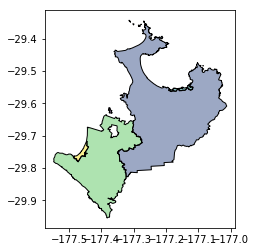

In [121]:
# Read Shapefile

path = DATA_DIR/'raw'/'NZ_AU01_region.shp'
au = gpd.read_file(str(path))
au.crs = CRS_NZTM
au = au.to_crs(CRS_WGS84)
au = au.rename(columns={'AU01': 'au2001', 'AU_DESC': 'au_name'})
print(au.shape)
print(au.head())

au.head().plot()


In [122]:
# Read region info

path = DATA_DIR/'raw'/'Geographical Table.csv'
f = pd.read_csv(path, dtype={'SAU': str})
f = f.rename(columns={
    'SAU': 'au2001',
    'TA': 'territory',
    'Region': 'region',
})
f = f.drop(['SAU.Desc', 'Water'], axis=1)
print(f.shape)
f.head()


(1842, 3)


,au2001,territory,region
0,500100,Far North District,Northland
1,500202,Far North District,Northland
2,500203,Far North District,Northland
3,500204,Far North District,Northland
4,500205,Far North District,Northland


In [123]:
# Merge geodata and region info and write to file

g = au.merge(f, on='au2001')
print(g.shape)
print(g.head())

path = DATA_DIR/'au2001.geojson'
with path.open('w') as tgt:
    tgt.write(g.to_json())


(1842, 5)
   au2001             au_name  \
0  500100              Awanui   
1  500202       Mangonui East   
2  500203  Taipa Bay-Mangonui   
3  500204       Mangonui West   
4  500205             Ahipara   

                                            geometry           territory  \
0  POLYGON ((-177.3681414718506 -29.6296874188288...  Far North District   
1  (POLYGON ((-177.2828555627479 -29.727994826984...  Far North District   
2  POLYGON ((-177.1184638694327 -29.5556501166188...  Far North District   
3  (POLYGON ((-177.2907442266485 -29.730263661102...  Far North District   
4  POLYGON ((-177.4499845476346 -29.7508951496223...  Far North District   

      region  
0  Northland  
1  Northland  
2  Northland  
3  Northland  
4  Northland  


# Prepare bond data

In [124]:
# Reshape and merge all rent data sets

def clean(f, name):
    f = f.copy()
    f = f.rename(columns={
        'SAU': 'au2001',
        'Property_Type': 'property_type',
        'Bedrooms': 'num_bedrooms'
    })

    # Drop subtotals
    cond = False
    for col in ['au2001', 'property_type', 'num_bedrooms']:
        cond |= f[col].str.contains('total', case=False)

    f = f[~cond].copy()
    
    # Reshape
    id_vars = ['au2001', 'property_type', 'num_bedrooms']
    value_vars = [c for c in f.columns if '-' in c]
    f = pd.melt(f, id_vars=id_vars, value_vars=value_vars,
      var_name='quarter', value_name=name)
    
    return f

paths = [
    DATA_DIR/'raw'/'Detailed Bonds Lodged.csv',
    DATA_DIR/'raw'/'Detailed Mean Rents.csv',
    DATA_DIR/'raw'/'Detailed Geomean Rents.csv',
]
names = ['count', 'rent_mean', 'rent_geo_mean']
frames = []
for path, name in zip(paths, names):
    f = pd.read_csv(path, dtype={'SAU': str})
    frames.append(clean(f, name))
    
f = reduce(lambda x, y: pd.merge(x, y), frames)

# Merge in region data
path = DATA_DIR/'raw'/'Geographical Table.csv'
g = pd.read_csv(path, dtype={'SAU': str})
g = g.rename(columns={
    'SAU': 'au2001', 
    'SAU.Desc': 'au_name', 
    'TA': 'territory',
    'Region': 'region',
})
f = f.merge(g)

# Merge in AU groups
path = DATA_DIR/'raw'/'Market Rent Areas.csv'
g = pd.read_csv(path, dtype={'SAU': str})
g = g.rename(columns={
    'SAU': 'au2001', 
    'MARKET RENT DESCRIPTION': 'au_group',
})
f = f.merge(g[['au2001', 'au_group']])

# Write to file
path = DATA_DIR/'rents.csv'
f.to_csv(str(path), index=False)
f.head()

,au2001,property_type,num_bedrooms,quarter,count,rent_mean,rent_geo_mean,au_name,territory,region,Water,au_group
0,500100,House,2,1993-03-01,NaN,NaN,NaN,Awanui,Far North District,Northland,0,Far North - Rural Far North
1,500100,House,3,1993-03-01,NaN,NaN,NaN,Awanui,Far North District,Northland,0,Far North - Rural Far North
2,500100,House,2,1993-06-01,NaN,NaN,NaN,Awanui,Far North District,Northland,0,Far North - Rural Far North
3,500100,House,3,1993-06-01,NaN,NaN,NaN,Awanui,Far North District,Northland,0,Far North - Rural Far North
4,500100,House,2,1993-09-01,NaN,NaN,NaN,Awanui,Far North District,Northland,0,Far North - Rural Far North


# Explorer rents

In [125]:
path = DATA_DIR/'rents.csv'
f = pd.read_csv(path, dtype={'au2001': str})
f.head()


,au2001,property_type,num_bedrooms,quarter,count,rent_mean,rent_geo_mean,au_name,territory,region,Water,au_group
0,500100,House,2,1993-03-01,NaN,NaN,NaN,Awanui,Far North District,Northland,0,Far North - Rural Far North
1,500100,House,3,1993-03-01,NaN,NaN,NaN,Awanui,Far North District,Northland,0,Far North - Rural Far North
2,500100,House,2,1993-06-01,NaN,NaN,NaN,Awanui,Far North District,Northland,0,Far North - Rural Far North
3,500100,House,3,1993-06-01,NaN,NaN,NaN,Awanui,Far North District,Northland,0,Far North - Rural Far North
4,500100,House,2,1993-09-01,NaN,NaN,NaN,Awanui,Far North District,Northland,0,Far North - Rural Far North


In [129]:
# Slice in time and aggregate 

def aggregate_rents(f, date, groupby_cols=('au_group', 'num_bedrooms')):
    """
    """
    cond = f['quarter'] >= date
    f = f[cond].copy()
    
    def my_agg(group):
        d = {}
        d['territory'] = group['territory'].iat[0]
        d['region'] = group['region'].iat[0]
        d['count'] = group['count'].sum()
        d['rent_mean'] = (group['rent_mean']*group['count']).sum()/d['count']
        d['rent_geo_mean'] = (group['rent_geo_mean']**(group['count']/d['count'])).prod()
        return pd.Series(d)

    g = f.groupby(groupby_cols).apply(my_agg).reset_index()
    return g

agg_rents = aggregate_rents(f, '2016-12-01')
agg_rents

,au_group,num_bedrooms,count,region,rent_geo_mean,rent_mean,territory
0,Ashburton - Entire District,1,NaN,Canterbury,NaN,NaN,Ashburton District
1,Ashburton - Entire District,2,48.0,Canterbury,291.100898,293.166667,Ashburton District
2,Ashburton - Entire District,3,153.0,Canterbury,337.794021,343.013072,Ashburton District
3,Ashburton - Entire District,4,NaN,Canterbury,NaN,NaN,Ashburton District
4,Ashburton - Entire District,5+,NaN,Canterbury,NaN,NaN,Ashburton District
5,Auckland - Avondale,1,NaN,Auckland,NaN,NaN,Auckland City
6,Auckland - Avondale,2,41.0,Auckland,427.172149,430.951220,Auckland City
7,Auckland - Avondale,3,80.0,Auckland,521.159953,524.212500,Auckland City
8,Auckland - Avondale,4,17.0,Auckland,611.705437,619.470588,Auckland City
9,Auckland - Avondale,5+,NaN,Auckland,NaN,NaN,Auckland City


In [131]:
cond = agg_rents['region'] == 'Auckland'
a = agg_rents[cond].copy()

def hits(group):
    d = {}
    d['hit_frac'] = group['count'].dropna().shape[0]/group['count'].shape[0]
    return pd.Series(d)

a.groupby('num_bedrooms').apply(hits).reset_index()

,num_bedrooms,hit_frac
0,1,0.707071
1,2,0.939394
2,3,1.000000
3,4,0.848485
4,5+,0.232323
